In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
# Test connection and path to images
!ls "/gdrive/My Drive/computer-vision-project/segmentation"

 augmented_images   validation
 models		    validation-labels
 processed_labels   vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
 train		   'vgg_unet_weights (1).best.hdf5'
 train-labels	    vgg_unet_weights.best.hdf5


In [3]:
 !pip install mxnet

     |████████████████████████████████| 28.4MB 1.4MB/s 
     |████████████████████████████████| 13.8MB 37.7MB/s 
ERROR: spacy 2.1.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.52 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4


In [0]:
%matplotlib inline
import os
from pathlib import Path
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
from lxml import etree
from mxnet import image, nd
from skimage.transform import resize
import glob  

In [0]:
def plot_pair(idx, features, labels):
    plt.subplot(121)
    plt.imshow(features[idx])
    plt.subplot(122)
    plt.imshow(labels[idx])
    plt.show()

### Read train, validation and test data

In [6]:

PATH_TO_SEGMENTATION = "/gdrive/My Drive/computer-vision-project/dataset_resampled/segmentation/"
IMAGE_SIZE = 128
NUM_CLASSES = 3

def read_images(filenames, subfolder):
    images = []
    for i in range(0, len(filenames)):
        img_path = PATH_TO_SEGMENTATION + subfolder + "/img" + str(i) + ".jpg"
        images.append(resize(io.imread(img_path), (IMAGE_SIZE, IMAGE_SIZE, 3)))
    return np.array(images).astype('float32')


filenames_train = [img for img in glob.glob(PATH_TO_SEGMENTATION + "train/*.jpg")]
filenames_train_labels = [img for img in glob.glob(PATH_TO_SEGMENTATION + "train-labels/*.jpg")]
filenames_validation = [img for img in glob.glob(PATH_TO_SEGMENTATION + "validation/*.jpg")]
filenames_validation_labels = [img for img in glob.glob(PATH_TO_SEGMENTATION + "validation-labels/*.jpg")]
filenames_test = [img for img in glob.glob(PATH_TO_SEGMENTATION + "test/*.jpg")]
filenames_test_labels = [img for img in glob.glob(PATH_TO_SEGMENTATION + "test-labels/*.jpg")]

train_features_resized = read_images(filenames_train, "train")
train_segmentations_resized = read_images(filenames_train_labels, "train-labels")

validation_features_resized = read_images(filenames_validation, "validation")
validation_segmentations_resized = read_images(filenames_validation_labels, "validation-labels")

test_features_resized = read_images(filenames_test, "test")
test_segmentations_resized = read_images(filenames_test_labels, "test-labels")

print(train_features_resized.shape)
print(train_segmentations_resized.shape)
print(validation_features_resized.shape)
print(validation_segmentations_resized.shape)
print(test_features_resized.shape)
print(test_segmentations_resized.shape)



(48, 128, 128, 3)
(48, 128, 128, 3)
(42, 128, 128, 3)
(42, 128, 128, 3)
(11, 128, 128, 3)
(11, 128, 128, 3)


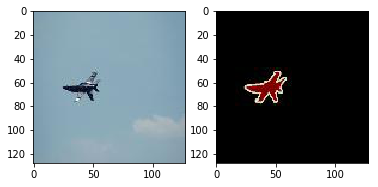

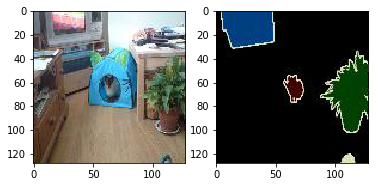

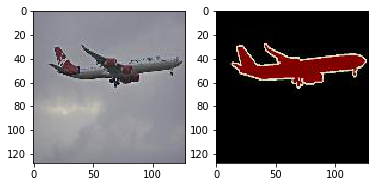

In [7]:
plot_pair(1, train_features_resized, train_segmentations_resized)
plot_pair(5, validation_features_resized, validation_segmentations_resized)
plot_pair(10, test_features_resized, test_segmentations_resized)

In [8]:
train_seg_labels = np.load(PATH_TO_SEGMENTATION + 'processed_labels/train.npy')
val_seg_labels = np.load(PATH_TO_SEGMENTATION + 'processed_labels/validation.npy')
test_seg_labels = np.load(PATH_TO_SEGMENTATION + 'processed_labels/test.npy')

print(len(train_seg_labels))
print(len(val_seg_labels))
print(len(test_seg_labels))

#Should be (img_size, img_size, num_classes)
print(train_seg_labels[0].shape)
print(val_seg_labels[0].shape)
print(test_seg_labels[0].shape)

48
42
11
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


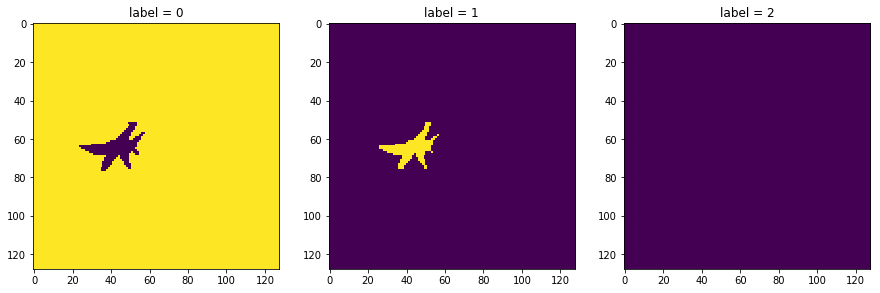

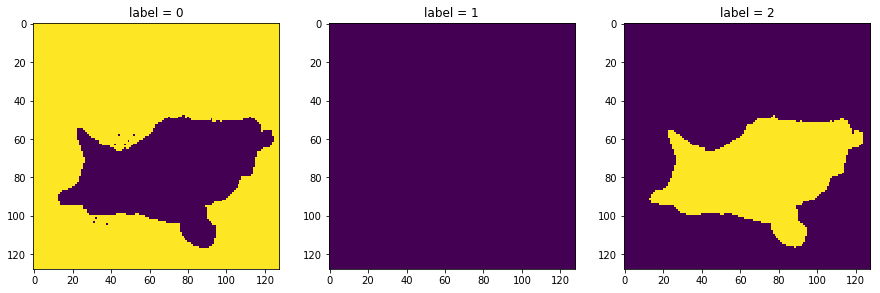

In [9]:
# Plot segmentations (sanity check)
n_classes = 3
def plot_segmentation(idx):
    img = train_seg_labels[idx]
    mi, ma = 0, n_classes-1
    n_classes_plot = n_classes
    fig = plt.figure(figsize=(15,10))
    for k in range(mi, ma+1):
        ax = fig.add_subplot(1, n_classes_plot, k+1)
        ax.imshow((img[:, :, k]))
        ax.set_title("label = {}".format(k))
        
plot_segmentation(1)
plot_segmentation(40)

In [10]:
## Import usual libraries
from keras.models import *
from keras.layers import *
warnings.filterwarnings("ignore")


## location of VGG weights
VGG_Weights_path = PATH_TO_SEGMENTATION + "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"


Using TensorFlow backend.


In [11]:
X_train = train_features_resized
y_train = np.array(train_seg_labels)

X_validation = validation_features_resized
y_validation = np.array(val_seg_labels)

X_test = test_features_resized
y_test = np.array(test_seg_labels)

X_trainval = np.concatenate((X_train,X_validation), axis = 0)
y_trainval = np.concatenate((y_train, y_validation), axis = 0)

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)
print(X_trainval.shape, y_trainval.shape)

(48, 128, 128, 3) (48, 128, 128, 3)
(42, 128, 128, 3) (42, 128, 128, 3)
(11, 128, 128, 3) (11, 128, 128, 3)
(90, 128, 128, 3) (90, 128, 128, 3)


In [12]:
aeroplanes = np.array(train_features_resized[:5]) #or train_features_normalized
cats = np.array(train_features_resized[35:40])

aeroplanes_labels = np.array(train_seg_labels[:5])
cats_labels = np.array(train_seg_labels[35:40])


X_dummy = np.concatenate((aeroplanes,cats), axis = 0)
print(X_dummy.shape)
y_dummy = np.concatenate((aeroplanes_labels, cats_labels), axis = 0)
print(y_dummy.shape)

(10, 128, 128, 3)
(10, 128, 128, 3)


In [14]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.initializers import Constant
from keras import optimizers
from keras.optimizers import Adam
np.random.seed(1337) # for reproducibility
from keras.callbacks import EarlyStopping
from keras.models import *
from keras.layers import *
warnings.filterwarnings("ignore")


smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Bilinear interpolation (reference: https://github.com/warmspringwinds/tf-image-segmentation/blob/master/tf_image_segmentation/utils/upsampling.py)
def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:filter_size, :filter_size]
    upsample_kernel = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights

def fcn_32s():
    inputs = Input(shape=(None, None, 3))
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    x = Conv2D(filters=NUM_CLASSES, kernel_size=(1, 1))(vgg16.output)
    x = Conv2DTranspose(filters=NUM_CLASSES, 
                        kernel_size=(64, 64),
                        strides=(32, 32),
                        padding='same',
                        activation='softmax',
                        kernel_initializer=Constant(bilinear_upsample_weights(32, NUM_CLASSES)))(x)
    model = Model(inputs=inputs, outputs=x)
    return model


model = fcn_32s()

adam = optimizers.Adam(lr=1e-4)
model.compile(
              loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])


es = EarlyStopping(monitor='val_acc', patience=5)

hist1 = model.fit(X_trainval,y_trainval,
#                   validation_data=(X_validation,y_validation),
                  callbacks=[es],
                  batch_size=16,epochs=9,verbose=1)

Epoch 1/9
90/90 [==============================] - 2s 20ms/step - loss: 0.5758 - acc: 0.8121
Epoch 2/9
90/90 [==============================] - 1s 6ms/step - loss: 0.4050 - acc: 0.8520
Epoch 3/9
90/90 [==============================] - 1s 6ms/step - loss: 0.3054 - acc: 0.8800
Epoch 4/9
90/90 [==============================] - 1s 7ms/step - loss: 0.2851 - acc: 0.8751
Epoch 5/9
90/90 [==============================] - 1s 6ms/step - loss: 0.2468 - acc: 0.8975
Epoch 6/9
90/90 [==============================] - 1s 7ms/step - loss: 0.2204 - acc: 0.9010
Epoch 7/9
90/90 [==============================] - 1s 7ms/step - loss: 0.1982 - acc: 0.9096
Epoch 8/9
90/90 [==============================] - 1s 6ms/step - loss: 0.1799 - acc: 0.9213
Epoch 9/9
90/90 [==============================] - 1s 6ms/step - loss: 0.1698 - acc: 0.9252


In [15]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(11, 128, 128) (11, 128, 128)


In [16]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=141820, #FP= 10662, #FN= 7831, IoU=0.885
class 01: #TP=  4721, #FP=  2659, #FN= 6307, IoU=0.345
class 02: #TP= 15190, #FP=  5172, #FN= 4355, IoU=0.615
_________________
Mean IoU: 0.615


In [17]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())
  
  
dice_coefficients = []
for i in range(10):
  dice_coefficients.append(dice(y_predi[i], y_testi[i]))

np.mean(dice_coefficients)

0.6158695316602376

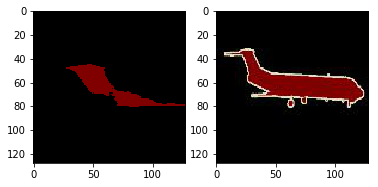

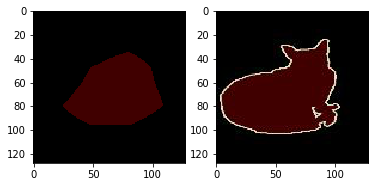

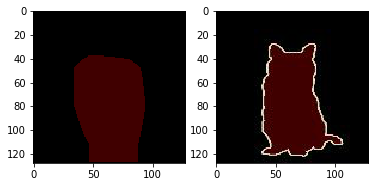

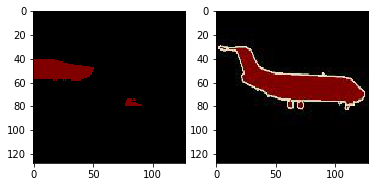

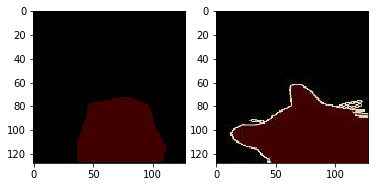

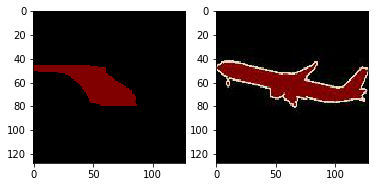

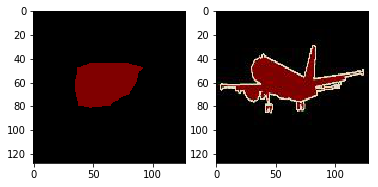

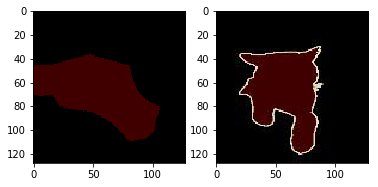

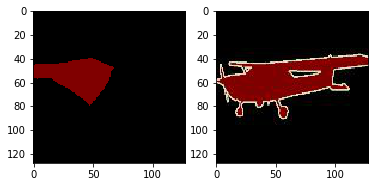

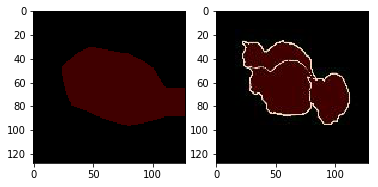

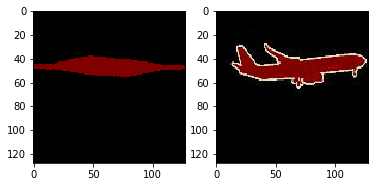

In [18]:
filter = ['background','aeroplane', 'cat'] 

# Use this as a lookup for the colors and the classes
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

indexes = [VOC_CLASSES.index(filter_item) for filter_item in filter]
VOC_COLORMAP_FILTER = [VOC_COLORMAP[index] for index in indexes]


def convert_labels_to_color(images):
    converted_images = []
    height, width = images[0].shape
    for image in images:
        new_image = np.zeros((height,width,3), np.uint8)
        for x in range(height-1):
            for y in range(width-1):
                values = VOC_COLORMAP_FILTER[image[x, y]]
                new_image[x, y] = (values[0], values[1], values[2])
        converted_images.append(new_image)
    return converted_images
  
converted_images = convert_labels_to_color(y_predi)

for i, img in enumerate(converted_images):
  plot_pair(i, converted_images, test_segmentations_resized)

In [0]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [0]:
PATH_TO_MODELS = PATH_TO_SEGMENTATION + 'models/'
def save_model(model, name):
    # serialize model to JSON
    if not os.path.exists(PATH_TO_MODELS):
        os.makedirs(PATH_TO_MODELS)
    model_json = model.to_json()
    with open(PATH_TO_MODELS + name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(PATH_TO_MODELS + name + ".h5")
    print("Saved model to disk")
    
save_model(model, "segmenter")